In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import hj_reachability as hj
import hj_reachability.shapes as shp
import pyspect as ps

In [2]:
class Set(ps.Set):

    vf: np.ndarray
    grid: hj.Grid
    timeline: np.ndarray
    dynamics: hj.Dynamics

    solver_settings = hj.SolverSettings.with_accuracy("low")
    
    def __init__(self, dynamics, grid, timeline, vf, **kwargs):
        super().__init__(**kwargs)

        self.dynamics = dynamics
        self.timeline = timeline
        self.grid = grid
        self.vf = vf

    def copy(self):
        return Set(self.dynamics, 
                   self.grid, 
                   self.timeline.copy(), 
                   self.vf.copy(), 
                   approx=self.approx)
    
    @classmethod
    def empty(self):
        return np.ones(self.grid.shape)
    
    def is_empty(self):
        return np.all(0 < self.vf)
    
    def membership(self, point):
        idx = self.grid.nearest_index(point)
        return self.vf[idx] <= 0
    
    def complement(self):
        s = super().complement()
        s.vf = np.asarray(-s.vf)
        return s
    
    def union(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().union(other)
        s.vf = np.asarray(np.minimum(self.vf, other.vf))
        return s
    
    def intersect(self, other):
        assert self.grid is other.grid, 'Grids must match'
        assert np.isclose(self.timeline, other.timeline).all(), 'Timelines must match'
        s = super().intersect(other)
        s.vf = np.asarray(np.maximum(self.vf, other.vf))
        return s
    
    def reach(self, constraints=None):
        s = super().reach(constraints)
        vf = hj.solve(self.solver_settings,
                      self.dynamics,
                      self.grid,
                      self.timeline,
                      self.vf,
                      constraints.vf)
        s.vf = np.asarray(vf)
        return s

    def rci(self):
        s = super().rci()
        s._make_tube()
        target = np.ones_like(s.vf)
        target[-1, ...] = s.vf[-1, ...]
        constraint = s.vf
        vf = hj.solver(self.solver_settings,
                       self.dynamics,
                       self.grid,
                       self.timeline,
                       target,
                       constraint)
        s.vf = np.asarray(np.flip(vf, axis=0))
        return s

    def _is_invariant(self):
        return len(self.vf.shape) != len(self.timeline.shape + self.grid.shape)

    def _make_tube(self):
        if self._is_invariant():    
            self.vf = np.concatenate([self.vf[np.newaxis, ...]] * len(self.timeline))


In [3]:

BACKGROUND = plt.imread('Eskilstuna-Intersection.png')

min_bounds = np.array([0.0, 0.0, -np.pi, -np.pi/5, +0])
max_bounds = np.array([6.0, 4.5, +np.pi, +np.pi/5, +1])
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(min_bounds, max_bounds),
                                                               (61, 46, 31, 7, 11),
                                                               periodic_dims=2)
print('dx =', grid.spacings[0], 'dy =', grid.spacings[1])

def plot_set(ax, vf, **kwargs):
    vf = shp.project_onto(vf, 0, 1) # project non-shared states to the shared states
    vf = np.where(vf <= 0, 0.5, np.nan)            
    vf = vf.T # imshow flips axis
    return [ax.imshow(vf, vmin=0, vmax=1, origin='lower', **kwargs)]

def plot_map(*pairs):
    plt.figure
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(9*4/3, 9))
    extent=[min_bounds[0], max_bounds[0],
            min_bounds[1], max_bounds[1]]
    ax.set_ylabel("y [m]")
    ax.set_xlabel("x [m]")
    ax.invert_yaxis()
    ax.imshow(BACKGROUND, extent=extent)
    for cmap, vf in pairs:
        plot_set(ax, vf, alpha=0.9, cmap=plt.get_cmap(cmap), extent=extent)
    fig.tight_layout()
    return fig

intersection = shp.intersection(shp.rectangle(grid, target_min=[3.15, 0.91], target_max=[5.15, 2.28]),
                                shp.hyperplane(grid, normal=[-1, 1],    offset=[3.4, 2.0]),
                                shp.hyperplane(grid, normal=[1, 1],     offset=[4.8, 2.0]))
print('Created intersection')
kyrkogatan_right = shp.union(intersection,
                             shp.rectangle(grid, target_min=[0,   0.91, +np.pi/2 - np.pi/5],    target_max=[4, 1.38, +np.pi/2 + np.pi/5]),
                             shp.rectangle(grid, target_min=[4.5, 0.91, +np.pi/2 - np.pi/5],    target_max=[6, 1.3,  +np.pi/2 + np.pi/5]))
print('Created kyrkogatan_right')
kyrkogatan_left = shp.union(intersection,
                            shp.rectangle(grid, target_min=[0,   1.4,  -np.pi/2 - np.pi/5], target_max=[4, 1.78, -np.pi/2 + np.pi/5]),
                            shp.rectangle(grid, target_min=[4.5, 1.31, -np.pi/2 - np.pi/5], target_max=[6, 1.68, -np.pi/2 + np.pi/5]))
print('Created kyrkogatan_left')
nygatan_up = shp.union(intersection,
                       shp.rectangle(grid, target_min=[4.2, 1.7, +np.pi - np.pi/5], target_max=[4.6, 4.5, -np.pi + np.pi/5]),
                       shp.rectangle(grid, target_min=[4.0, 0.0, +np.pi - np.pi/5], target_max=[4.3, 1.2, -np.pi + np.pi/5]))
print('Created nygatan_up')
nygatan_down = shp.union(intersection,
                         shp.rectangle(grid, target_min=[3.7, 1.7, -np.pi/5], target_max=[4.15, 4.5, +np.pi/5]),
                         shp.rectangle(grid, target_min=[3.8, 0.0, -np.pi/5], target_max=[4.1,  1.2, +np.pi/5]))
print('Created nygatan_down')
parking_lot = shp.union(shp.rectangle(grid, target_min=[1.1, 2.05], target_max=[1.5, 4.5]),
                        shp.rectangle(grid, target_min=[1.1, 2.45], target_max=[3.3, 2.8]),
                        shp.rectangle(grid, target_min=[3.05, 2.5], target_max=[3.45, 4.1]),
                        shp.rectangle(grid, target_min=[1.1, 3.65], target_max=[3.45, 4.1]),
                        shp.rectangle(grid, target_min=[1.125, 1.6], target_max=[1.45, 2.25]))
print('Created parking_lot')
parking_spot_entry_1 = shp.rectangle(grid, target_min=[1.5, 4.0], target_max=[1.9, 4.3])
parking_spot_entry_2 = shp.rectangle(grid, target_min=[2.25, 3.5], target_max=[2.7, 3.8])
parking_spot_1 = shp.rectangle(grid, target_min=[1.60, 4.15, +np.pi/2 - np.pi/5], target_max=[1.8, 4.5, +np.pi/2 + np.pi/5])
parking_spot_2 = shp.rectangle(grid, target_min=[2.35, 3.25, -np.pi/2 - np.pi/5], target_max=[2.6, 3.6, -np.pi/2 + np.pi/5])
print('Created parking_spots')
exit_zone = shp.rectangle(grid, target_min=[4.25, 4.1], target_max=[4.6, 4.45])
entry_zone = shp.rectangle(grid, target_min=[0.05, 1.4], target_max=[0.4, 1.75])
print('Created entry_zone and exit_zone')

dx = 0.10000001 dy = 0.1
Created intersection
Created kyrkogatan_right
Created kyrkogatan_left
Created nygatan_up
Created nygatan_down
Created parking_lot
Created parking_spots
Created entry_zone and exit_zone


In [4]:
def new_timeline(target_time, start_time=0, time_step=0.2):
    assert time_step > 0
    is_forward = target_time >= start_time
    target_time += 1e-5 if is_forward else -1e-5
    time_step *= 1 if is_forward else -1
    return np.arange(start_time, target_time, time_step)

timeline = new_timeline(5)

reach_dynamics = hj.systems.Bicycle5D(min_steer=-np.pi, 
                                      max_steer=+np.pi,
                                      min_accel=-0.5,
                                      max_accel=+0.5).with_mode('reach')


r1 = ps.Until(p1=..., p2=...)

out = r1(p1=Set(reach_dynamics, grid, timeline, shp.make_tube(timeline, 
                                                              shp.union(kyrkogatan_right, nygatan_up))), 
            p2=Set(reach_dynamics, grid, timeline, shp.make_tube(timeline, exit_zone)))


2024-03-02 15:44:24.099854: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.22GiB (rounded to 1312795904)requested by op 
2024-03-02 15:44:24.100170: W external/tsl/tsl/framework/bfc_allocator.cc:497] *_______**************************************************************************__________________
2024-03-02 15:44:24.100747: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2461] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1312795904 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.42GiB
              constant allocation:       216B
        maybe_live_out allocation:  664.31MiB
     preallocated temp allocation:    1.22GiB
                 total allocation:    3.29GiB
              total fragmentation:  434.36MiB (12.88%)
Peak buffers:
	Buffer 1:
		Size: 664.31MiB
		Entry Parameter Subshape: f32[26,61,46,31,7,11]

	B

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1312795904 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.42GiB
              constant allocation:       216B
        maybe_live_out allocation:  664.31MiB
     preallocated temp allocation:    1.22GiB
                 total allocation:    3.29GiB
              total fragmentation:  434.36MiB (12.88%)
Peak buffers:
	Buffer 1:
		Size: 664.31MiB
		Entry Parameter Subshape: f32[26,61,46,31,7,11]
		==========================

	Buffer 2:
		Size: 664.31MiB
		Entry Parameter Subshape: f32[26,61,46,31,7,11]
		==========================

	Buffer 3:
		Size: 664.31MiB
		Operator: op_name="jit(solve)/jit(main)/concatenate[dimension=0]" source_file="/media/Shared/Projects/Python/pyspect/src/hj_reachability/solver.py" source_line=171
		XLA Label: concatenate
		Shape: f32[26,61,46,31,7,11]
		==========================

	Buffer 4:
		Size: 638.76MiB
		Operator: op_name="jit(solve)/jit(main)/broadcast_in_dim[shape=(25, 61, 46, 31, 7, 11) broadcast_dimensions=()]" source_file="/media/Shared/Projects/Python/pyspect/src/hj_reachability/solver.py" source_line=173
		XLA Label: broadcast
		Shape: f32[25,61,46,31,7,11]
		==========================

	Buffer 5:
		Size: 127.75MiB
		Entry Parameter Subshape: f32[61,46,31,7,11,5]
		==========================

	Buffer 6:
		Size: 25.55MiB
		Operator: op_name="jit(solve)/jit(main)/max" source_file="/media/Shared/Projects/Python/pyspect/src/hj_reachability/solver.py" source_line=161
		XLA Label: fusion
		Shape: f32[61,46,31,7,11]
		==========================

	Buffer 7:
		Size: 25.55MiB
		Operator: op_name="jit(solve)/jit(main)/max" source_file="/media/Shared/Projects/Python/pyspect/src/hj_reachability/solver.py" source_line=161
		XLA Label: fusion
		Shape: f32[1,61,46,31,7,11]
		==========================

	Buffer 8:
		Size: 244B
		Entry Parameter Subshape: f32[61]
		==========================

	Buffer 9:
		Size: 184B
		Entry Parameter Subshape: f32[46]
		==========================

	Buffer 10:
		Size: 128B
		XLA Label: tuple
		Shape: (s32[], f32[], f32[61,46,31,7,11], token[], f32[25,61,46,31,7,11], /*index=5*/f32[26], f32[], f32[], f32[61,46,31,7,11,5], f32[], /*index=10*/f32[], f32[], f32[], f32[], f32[26,61,46,31,7,11], /*index=15*/f32[26,61,46,31,7,11])
		==========================

	Buffer 11:
		Size: 124B
		Entry Parameter Subshape: f32[31]
		==========================

	Buffer 12:
		Size: 104B
		Entry Parameter Subshape: f32[26]
		==========================

	Buffer 13:
		Size: 100B
		XLA Label: constant
		Shape: s32[25]
		==========================

	Buffer 14:
		Size: 96B
		XLA Label: tuple
		Shape: (f32[], f32[61,46,31,7,11], token[], f32[], f32[], /*index=5*/f32[61,46,31,7,11,5], f32[], f32[], f32[], f32[], /*index=10*/f32[], f32[])
		==========================

	Buffer 15:
		Size: 44B
		Entry Parameter Subshape: f32[11]
		==========================



In [ ]:
m = intersection.data.nbytes / 1024 / 1024
print(f'Intersection size: {m:.2f} MB')

Intersection size: 51.10 MB


/tmp/ipykernel_22332/2322949170.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_map(


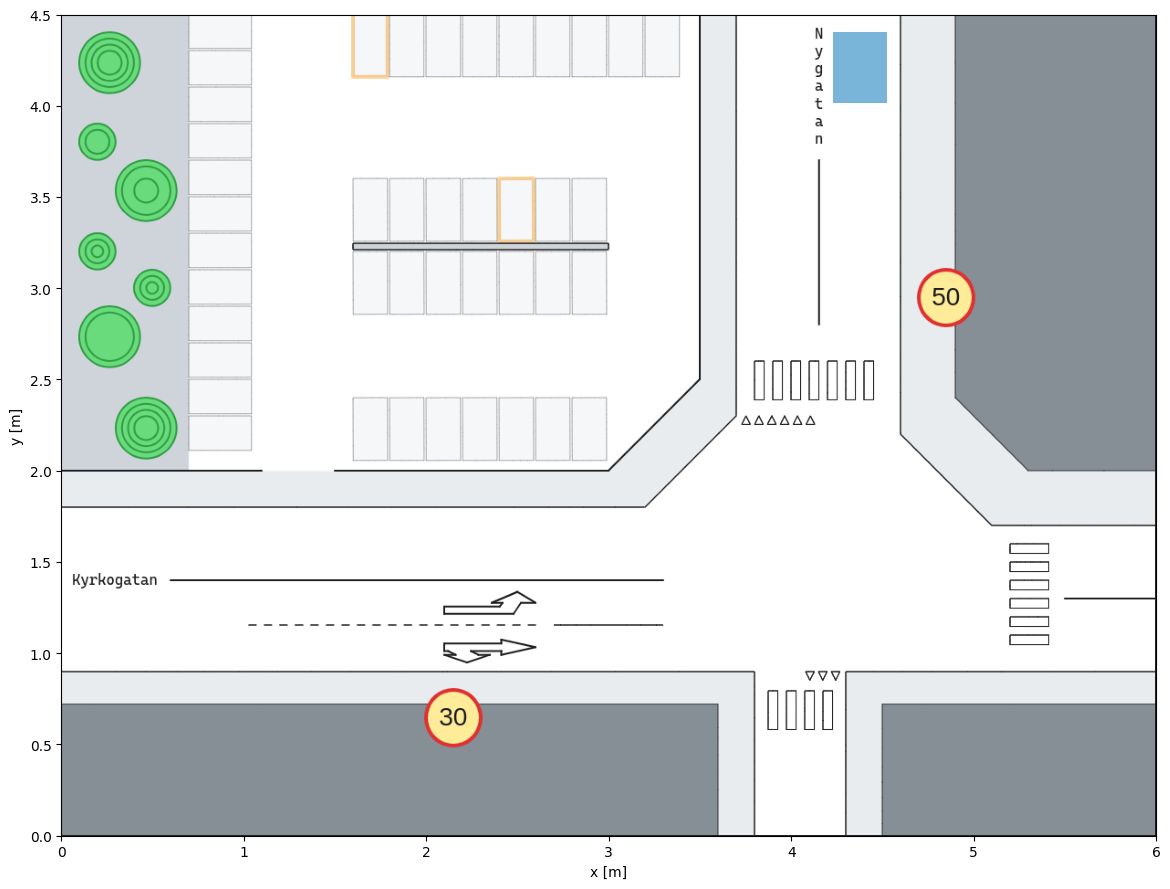

In [ ]:
# entry at kyrkogatan from the left
plot_map(
    ('Blues', shp.project_onto(out['...'].vf, 1, 2)),
).show()

In [ ]:
print(out['...'].vf.shape)
print(out['...'].vf[-6].shape)
print(shp.project_onto(out['...'].vf[-6], 0, 1).shape)

(16, 61, 46, 31, 7, 11)
(61, 46, 31, 7, 11)
(61, 46)
